# Experiment: Reconstruction of simulated data with other models + multi-model ensemble

I perform Pseudoproxy-Experiments where the true climate field differs is not the one used as a prior. Only anomalies are reconstructed and I also test the multi-model ensemble for reconstructing the true model. I test both the multi-model ensemble with all 5 models, and also without the true model inside (will there be a difference, or is the 4 model ensemble already good enough).

- Locations: Sisal + iso2k (100 proxies) 
- 1 Repetition
- direct d18O, no proxy system model (SNR=5, SNR=1, SNR=0.5)
- take the downsampled models first (for having results quickly)
- Yearly Timescale. Then also test 1 + 10 + 20 Year Timescale
- Years: Choose model years present in all simulations (851 - 1849)

- Anomaly: BG + HX, but also one model bias run (no anomalies would be interesting)

Wrapper takes the different models/multi-model as prior and also does the jack-knifing (leave one model out.)

Visualization:
 - Swarm-Plot for different metrics and models (Corr/CE/RMSE)
 
**Number of experiment configs in total**
 3 SNR x 2 timescales x 2bias/debias = 12 -> 12 Swarm Plots in Total (5*7=35 dots per swarm plot (5models +2 mme))
 
**HINT** Give the output folder similar names, such that for making the plots the paths can be adapted easily with control H. (search and replace)

In [2]:
###CONFIG DICTIONARY

#lists are sometimes necessary, especially if we use multiple proxy-DBs (e.g. SISAL and iso2k)
#and multiple timescales

cfg = {
#BASIC PARAMS
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'oro': None,
'reconstruct':['tsurf','d18O','prec'], 
'output_folder':'PPE_altphys_debiased_SNR5', #in cwd
'output_file':'dummy',
 'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':True, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
###PROXYS
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1], #irrelevant for PPE
'time_scales': ['median'], 
'proxy_time':['0851','1849'], 
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
'timescales':[1], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True, #e.g if a yearly resolved proxy is also to be used in the 5,10 year mean reconstruction
###PSM
'psm':[None,None], 
'interpol':None, #None/'dw'
'var_psm': ['d18O','d18O'] ,
'speleo':{
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'mean', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},
#currently this only works for one Database files, probably at some point that needs to be more flexible
'linear':{
    'variable': 'tsurf' , #variable to regress against
    'type': 'anom' , #absolute value or anomaly
    'anom_time': None , #None for full simulation, or time-list 
    'uniform': None, # if you just want one linear formula to rule them all [slope, intercept]
    #names of the regression parameters in the proxy-db
    'slope': 'slope' ,
    'intercept': 'intercept',
    'error': 'error', #make sure that the error in the database info is really the regression error *variance*, not standard error.
},
###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': True,
    'SNR': [5,5], #signal to noise variance ratio
    'noise_type': 'w', #'w'/'r'
    'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1],[1]], 
    'source': 'external', #internal/external
    'other_model': 
    {'vp':{'tsurf':'/home/ldap-server/draco/cleaned_data/final/CESM_tsurf_850_1850.nc',
    'prec':'/home/ldap-server/draco/cleaned_data/final/CESM_prec_850_1850.nc',
    'd18O':'/home/ldap-server/draco/cleaned_data/final/CESM_d18O_850_1850.nc',
    'evap': '/home/ldap-server/draco/cleaned_data/final/CESM_evap_850_1850.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','p_bootstrap','eff_p_value','CE','RMSE','RMSPE','MAE','MAPE'],
    'psm' : {'speleo':{   'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}, 'icecore': None},
},
    # cfg['ppe']['psm']= {'speleo':None, 'icecore': None} # if the config from above for the psm (which gives the obs-from-model) shall be different for the pseudoproxies.
#else just leave it as {'speleo':None, 'icecore': None} 
    
###KALMAN-FILTER
'time': ['0851','1849'], #covered by all models
'nens':100, #ensemble members
'reps':1, #Monte Carlo
'full_fields': True, 
'proxy_frac': 100, #choose 100 random proxies
'extra_assi': 
    {
        'globalmean':None, #None or list of variables
        'lat_mean': None, #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #/ 'HX'
'anomaly_time': None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

In [3]:
#paths to all models (downsampled to Echam resolution)

multi_prior_ds=[{
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       }
},
#I checked once again that nothing with the longitudes is wrong (all go from 0 to 360)
{
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/downsampled/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/downsampled/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/downsampled/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/downsampled/hadcm3_oro.nc',
'iCESM':'/home/mchoblet/paleoda/data/orographies/downsampled/icesm_oro.nc',
}]

#upsampled multiprior
multi_prior_up=[{
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/upsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/upsampled/iHADCM3_slp_801_1952.nc',
       }
},
#I checked once again that nothing with the longitudes is wrong (all go from 0 to 360)
{
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/upsampled/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/upsampled/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/upsampled/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/upsampled/hadcm3_oro.nc',
'iCESM':'/home/mchoblet/paleoda/data/orographies/upsampled/icesm_oro.nc',
}]

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import copy

%load_ext autoreload
%autoreload 2

/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((setuptools 63.4.1 (/home/mchoblet/miniconda3/envs/paleoda/lib/python3.10/site-packages), Requirement.parse('setuptools<60'), {'numba'}))'.
  numba.core.entrypoints.init_all()


In [6]:
def foreign_model_exp(paths,cfg):
    """
    Paths is the multi-prior variable (where the second one is orography just in case). Hence treat first element of paths, paths[0] as the dict with paths.
    
    """
    cfg_exp=cfg.copy()

    #loop over proxy origin
    for i1,p1 in tqdm.tqdm(paths[0].items()):
        #if i1=='iHadCM3':
            
        cfg_exp=copy.deepcopy(cfg)
        cfg_exp['multi_model_prior']=None

        cfg_exp['ppe']['other_model']['vp']=p1


        #loop over priors 
        for i2,p2 in paths[0].items():
            cfg_exp['vp']=p2
            cfg_exp['output_file']=str(i1)+'_PP_'+str(i2)+'_prior'
            wrapper.paleoda_wrapper(cfg_exp)

        #use multi-model_ensemble
        cfg_exp['multi_model_prior']=paths
        cfg_exp['output_file']=str(i1)+'_PP_'+'mme'+'_prior'
        wrapper.paleoda_wrapper(cfg_exp)


        #use multi-model_ensemble (leave one out)
        copied_paths=copy.deepcopy(paths[0])
        #delete current proxy origin
        del copied_paths[i1]
        #put back into list form
        copied_paths=[copied_paths]

        cfg_exp['multi_model_prior']=copied_paths
        cfg_exp['output_file']=str(i1)+'_PP_'+'mme_loo'+'_prior'
        wrapper.paleoda_wrapper(cfg_exp)

In [7]:
#Code for plotting
#create dataframe and then plot it as a swarm plot
#the key to have the many-files-plotted is that the file-name has a consistent structure

def multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased/',
                          models=['iCESM','Echam','GISS','iHadCM3','isoGSM'],
                          priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],
                         metric='tsurf_Corr'):
        """
        Returns all global-metrics in a Dataframe form.
        Basepath with / at the end.
        """
        
        #create Dataframe Columns
        prior_col=np.concatenate(np.repeat([priors],len(models),axis=0))
        models_col=np.repeat(models,len(priors))

        #loop over models and compute the metric
        results=[]
        for mod in models:
            for p in priors:
                string=basepath+mod+'_PP_'+p+'_prior.nc'
                data=xr.open_dataset(string)[metric]
                results.append(utils.globalmean(data).values.tolist())
        all_data={
            'metric':results,
            'model': models_col,
            'prior':prior_col,}
        

        df=pd.DataFrame(all_data)
        return df

def swarm_plot(df, name='',models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title=''):
    
    sns.set_palette("colorblind")

    si = 15
    fig = plt.figure(figsize=(12,8))
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="prior",size=si,marker='o',)

    handles, labels = ax.get_legend_handles_labels()
    plt.xticks(np.arange(len(models)),models)
    plt.xlabel('Models for Pseudoproxies (Truth)',fontsize=20)
    plt.xticks(rotation=45,ha="right",fontsize=16)
    plt.ylabel(name,fontsize=20)
    plt.yticks(fontsize=16)
    plt.ylim(0,0.6)
    l = plt.legend(handles, labels, loc='upper right',frameon=True,fontsize=14)
    plt.title(title,fontsize=20)
    plt.grid()

    if savename is not None:
        strg='/home/mchoblet/paleoda/results/plots/'+savename+'.pdf'
        plt.savefig(strg, format='pdf',bbox_inches='tight')

    

## Run experiments

In [69]:
foreign_model_exp(multi_prior_ds,cfg)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  


100%|██████████| 1/1 [00:13<00:00, 13.92s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc



100%|██████████| 1/1 [00:13<00:00, 13.83s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850


100%|██████████| 1/1 [00:13<00:00, 13.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:13<00:00, 13.95s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:13<00:00, 13.83s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:53<00:00, 113.90s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:24<00:00, 84.49s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [11:16<45:07, 677.00s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly


100%|██████████| 1/1 [00:13<00:00, 13.85s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc


100%|██████████| 1/1 [00:13<00:00, 13.82s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_85


100%|██████████| 1/1 [00:13<00:00, 13.91s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN P


100%|██████████| 1/1 [00:13<00:00, 13.82s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:13<00:00, 13.83s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:58<00:00, 118.20s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:23<00:00, 83.83s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [22:34<33:52, 677.54s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing y


100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.n


100%|██████████| 1/1 [00:13<00:00, 13.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_8


100%|██████████| 1/1 [00:13<00:00, 13.82s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:13<00:00, 13.73s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:13<00:00, 13.76s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:53<00:00, 113.32s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /ho


100%|██████████| 1/1 [01:23<00:00, 83.57s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [33:45<22:28, 674.18s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly


100%|██████████| 1/1 [00:13<00:00, 13.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
c


100%|██████████| 1/1 [00:13<00:00, 13.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_


100%|██████████| 1/1 [00:13<00:00, 13.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRI


100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:13<00:00, 13.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  


100%|██████████| 1/1 [01:57<00:00, 117.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /hom


100%|██████████| 1/1 [01:24<00:00, 84.21s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [45:13<11:19, 679.70s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 


100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_195


100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18


100%|██████████| 1/1 [00:13<00:00, 13.68s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN 


100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:13<00:00, 13.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  fro


100%|██████████| 1/1 [01:59<00:00, 119.50s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /


100%|██████████| 1/1 [01:22<00:00, 82.81s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [56:46<00:00, 681.34s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


In [10]:
import pandas as pd

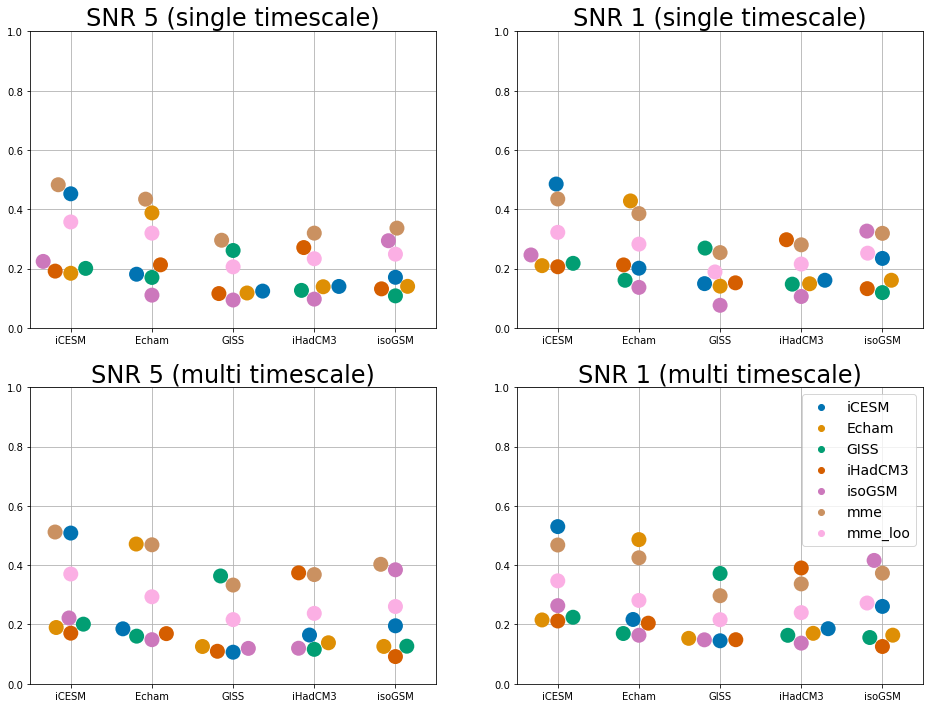

In [61]:
# loop/subplot



sns.set_palette("colorblind")
si = 15
fig, axs = plt.subplots(2,2,figsize=(16,12))
models=['iCESM','Echam','GISS','iHadCM3','isoGSM']

titles=['SNR 5 (single timescale)','SNR 1 (single timescale)','SNR 5 (multi timescale)','SNR 1 (multi timescale)']

savename=None
met='Corr'

paths=['/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased/',
       '/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1/',
       '/home/mchoblet/paleoda/results/experiments/PPE_foreign_model_debiased_SNR5_mts/',
       '/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1_mts/']

for i in range(4):
    
    title=titles[i]
    ax1=axs.flatten()[i]
    
    name='Correlation'
    
    if i==3:
        legend='auto'
    else:
        legend=False
    
    df=multi_model_dataframe(basepath=paths[i],metric=('tsurf_'+met))
    
    
    ax=sns.swarmplot(data=df,x="model", y="metric", hue="prior",size=si,marker='o',ax=ax1,legend=legend)
    

    handles, labels = ax.get_legend_handles_labels()
    ax1.set_xticks(np.arange(len(models)),models)
    ax1.set_xlabel('',fontsize=20)
    #ax1.set_xticks(rotation=45,ha="right",fontsize=16)
    ax1.set_ylabel('',fontsize=20)
    #ax1.set_yticks(fontsize=16)
    ax1.set_ylim(0,1)
    ax1.set_title(title,fontsize=24)
    
    if i==3:
        #x1.legend()
        l = ax1.legend(handles, labels, loc='upper right',frameon=True,fontsize=14)
    #plt.title(title,fontsize=20)
    ax1.grid()

if savename is not None:
    strg='/home/mchoblet/paleoda/results/plots/'+savename+'.pdf'
    plt.savefig(strg, format='pdf',bbox_inches='tight')


plt.savefig('/home/mchoblet/paleoda/results/plots/thesis_draft/multi_model.pdf', format='pdf',bbox_inches='tight')

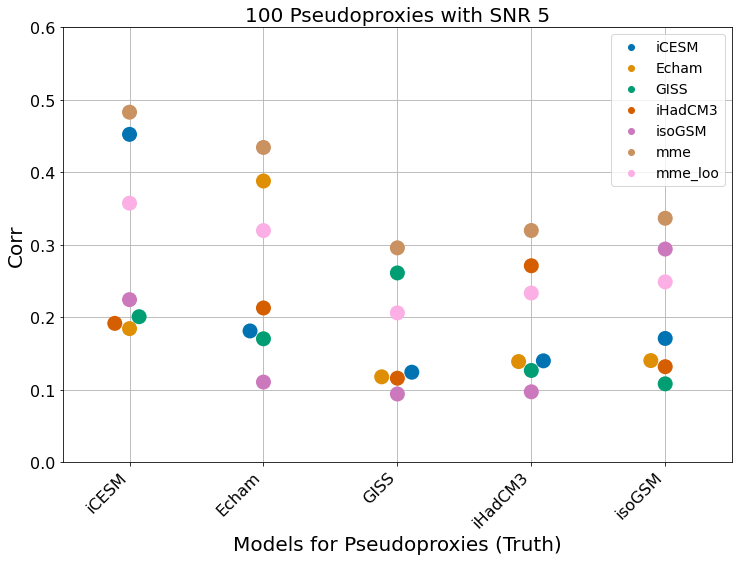

In [58]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 5')



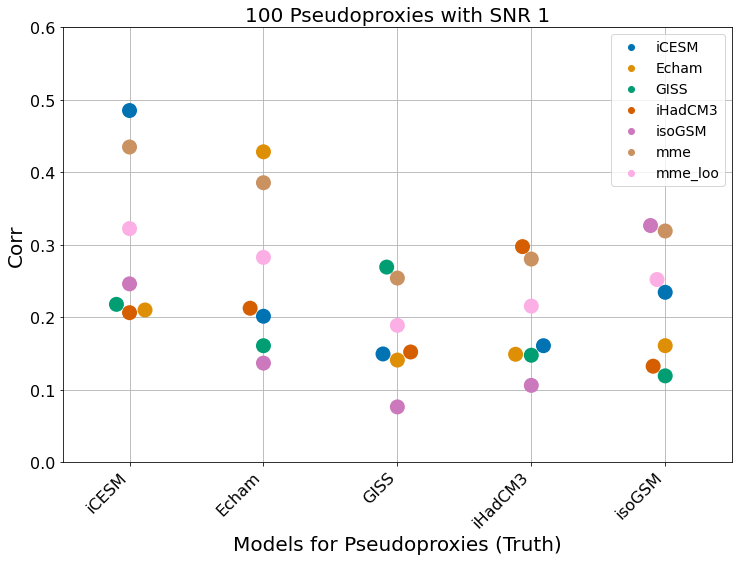

In [17]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 1')

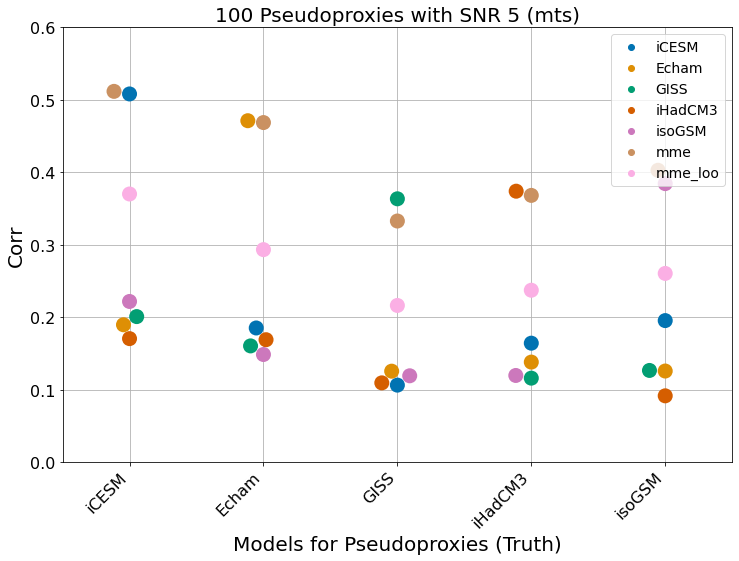

In [24]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_foreign_model_debiased_SNR5_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 5 (mts)')


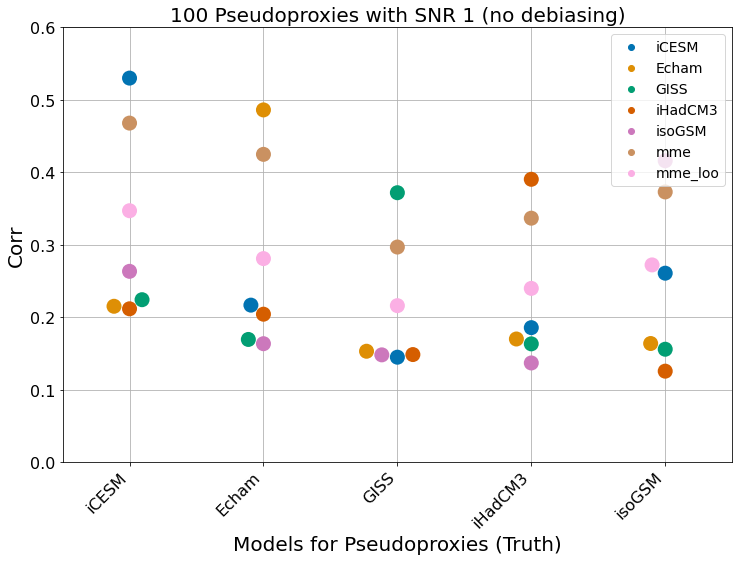

In [21]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 1 (no debiasing)')


In [70]:
#lower SNR experiment

cfg_2=copy.deepcopy(cfg)
cfg_2 ['output_folder']='PPE_altphys_debiased_SNR1'
cfg_2['ppe']['SNR']=[[1],[1]]
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  


100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc



100%|██████████| 1/1 [00:13<00:00, 13.67s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850


100%|██████████| 1/1 [00:13<00:00, 13.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:13<00:00, 13.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:13<00:00, 13.63s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [02:03<00:00, 123.08s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:23<00:00, 83.31s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [11:23<45:33, 683.50s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly


100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc


100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_85


100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN P


100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:13<00:00, 13.68s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:57<00:00, 117.55s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:23<00:00, 83.95s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [22:42<34:02, 680.91s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing y


100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.n


100%|██████████| 1/1 [00:13<00:00, 13.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_8


100%|██████████| 1/1 [00:13<00:00, 13.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:13<00:00, 13.76s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:52<00:00, 112.43s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /ho


100%|██████████| 1/1 [01:23<00:00, 83.64s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [33:55<22:34, 677.45s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly


100%|██████████| 1/1 [00:13<00:00, 13.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
c


100%|██████████| 1/1 [00:13<00:00, 13.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_


100%|██████████| 1/1 [00:13<00:00, 13.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRI


100%|██████████| 1/1 [00:13<00:00, 13.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:13<00:00, 13.80s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  


100%|██████████| 1/1 [02:01<00:00, 121.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /hom


100%|██████████| 1/1 [01:22<00:00, 82.97s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [45:28<11:23, 683.36s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 


100%|██████████| 1/1 [00:13<00:00, 13.73s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_195


100%|██████████| 1/1 [00:13<00:00, 13.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18


100%|██████████| 1/1 [00:13<00:00, 13.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN 


100%|██████████| 1/1 [00:13<00:00, 13.77s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:13<00:00, 13.78s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  fro


100%|██████████| 1/1 [01:55<00:00, 115.55s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /


100%|██████████| 1/1 [01:26<00:00, 86.20s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [57:01<00:00, 684.26s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


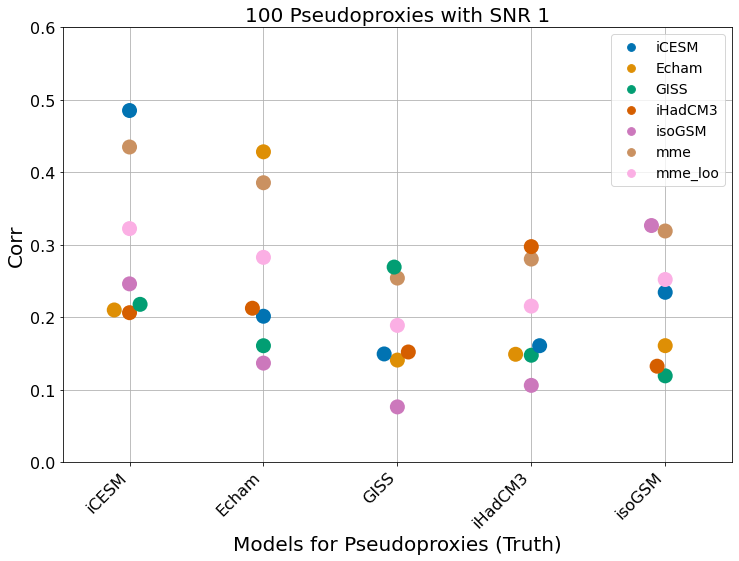

In [18]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 1')
plt.show()

In [ ]:
"""
met='CE'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()
"""

In [105]:
#lower SNR experiment (realistic values)

cfg_2=copy.deepcopy(cfg)
cfg_2 ['output_folder']='PPE_altphys_debiased_SNR05'
cfg_2['ppe']['SNR']=[[0.5],[0.5]]
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  


100%|██████████| 1/1 [00:13<00:00, 13.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc



100%|██████████| 1/1 [00:12<00:00, 12.95s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850


100%|██████████| 1/1 [00:15<00:00, 15.45s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:13<00:00, 13.01s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:13<00:00, 13.05s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:53<00:00, 113.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:23<00:00, 83.99s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [11:15<45:01, 675.48s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly


100%|██████████| 1/1 [00:13<00:00, 13.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc


100%|██████████| 1/1 [00:12<00:00, 13.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_85


100%|██████████| 1/1 [00:12<00:00, 12.99s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN P


100%|██████████| 1/1 [00:13<00:00, 13.01s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:13<00:00, 13.01s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:53<00:00, 113.94s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:26<00:00, 86.73s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [22:30<33:45, 675.29s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing y


100%|██████████| 1/1 [00:15<00:00, 15.62s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.n


100%|██████████| 1/1 [00:15<00:00, 15.69s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_8


100%|██████████| 1/1 [00:13<00:00, 13.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:15<00:00, 15.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:15<00:00, 15.58s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:52<00:00, 112.92s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /ho


100%|██████████| 1/1 [01:27<00:00, 87.18s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [33:56<22:40, 680.14s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly


100%|██████████| 1/1 [00:13<00:00, 13.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
c


100%|██████████| 1/1 [00:12<00:00, 13.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_


100%|██████████| 1/1 [00:12<00:00, 12.99s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRI


100%|██████████| 1/1 [00:12<00:00, 12.99s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:12<00:00, 12.99s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  


100%|██████████| 1/1 [02:01<00:00, 121.07s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /hom


100%|██████████| 1/1 [01:23<00:00, 83.80s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [45:24<11:23, 683.30s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 


100%|██████████| 1/1 [00:13<00:00, 13.18s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_195


100%|██████████| 1/1 [00:13<00:00, 13.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18


100%|██████████| 1/1 [00:12<00:00, 13.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN 


100%|██████████| 1/1 [00:13<00:00, 13.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:12<00:00, 12.99s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  fro


100%|██████████| 1/1 [02:00<00:00, 120.89s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /


100%|██████████| 1/1 [01:26<00:00, 86.51s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [57:01<00:00, 684.35s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


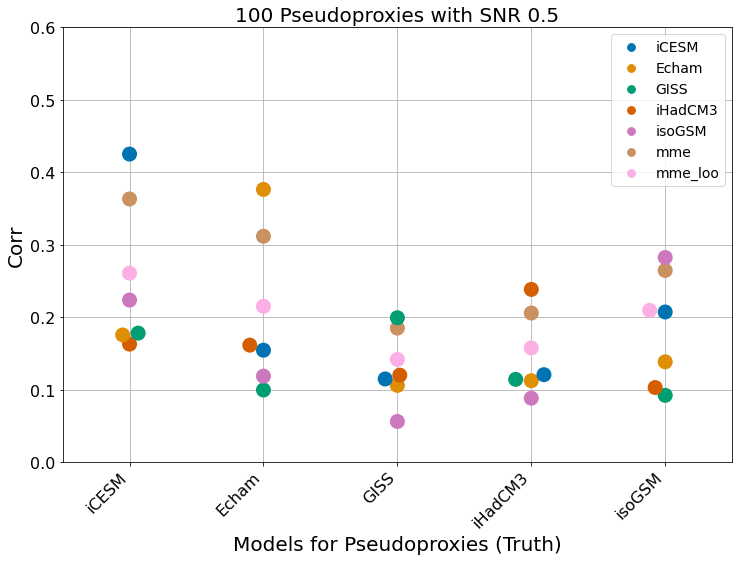

"\nmet='CE'\ndf=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR05/',metric=('tsurf_'+met))\nswarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)\nplt.show()\n"

In [36]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR05/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename='multi_model',title='100 Pseudoproxies with SNR 0.5')
plt.show()

"""
met='CE'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR05/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()
"""

# Same with multiple timescales (index: _mts)

In [116]:
xr.open_dataset('/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc')

<xarray.Dataset>
Dimensions:      (time: 12000, lon: 192, lat: 94)
Coordinates:
  * time         (time) object 0851-01-31 00:00:00 ... 1850-12-31 00:00:00
  * lon          (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat          (lat) float64 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
Data variables:
    d18O         (time, lat, lon) float32 ...
    spatial_ref  int64 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  COARDS
    history:      Mon Nov 15 18:42:31 2021: cdo setname,dO18 CCSM_d18O_851_18...
    calendar:     standard
    comments:     file created by grads using lats4d available from http://da...
    model:        geos/das
    center:       gsfc
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [ ]:
xr.open_dataset/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc

In [119]:
cfg_2=copy.deepcopy(cfg)
cfg_2['ppe']['multi_timescale']=[[1,10,20],[1,10,20]]
cfg_2 ['output_folder']='PPE_foreign_model_debiased_SNR5_mts'
foreign_model_exp(multi_prior_ds,cfg_2)


  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  


100%|██████████| 1/1 [00:21<00:00, 21.62s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc



100%|██████████| 1/1 [00:20<00:00, 20.49s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850


100%|██████████| 1/1 [00:20<00:00, 20.77s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:20<00:00, 20.92s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:20<00:00, 20.84s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [02:31<00:00, 151.26s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:51<00:00, 111.91s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [12:56<51:46, 776.65s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly


100%|██████████| 1/1 [00:22<00:00, 22.13s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc


100%|██████████| 1/1 [00:22<00:00, 22.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_85


100%|██████████| 1/1 [00:21<00:00, 21.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN P


100%|██████████| 1/1 [00:21<00:00, 21.60s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:21<00:00, 21.49s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [02:40<00:00, 160.26s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:51<00:00, 111.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [26:05<39:11, 783.95s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing y


100%|██████████| 1/1 [00:21<00:00, 21.93s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.n


100%|██████████| 1/1 [00:21<00:00, 21.49s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_8


100%|██████████| 1/1 [00:21<00:00, 21.29s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:21<00:00, 21.29s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:21<00:00, 21.18s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [02:27<00:00, 147.92s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /ho


100%|██████████| 1/1 [01:50<00:00, 110.21s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [38:55<25:54, 777.40s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly


100%|██████████| 1/1 [00:21<00:00, 21.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
c


100%|██████████| 1/1 [00:21<00:00, 21.45s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_


100%|██████████| 1/1 [00:21<00:00, 21.30s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRI


100%|██████████| 1/1 [00:21<00:00, 21.25s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:21<00:00, 21.34s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  


100%|██████████| 1/1 [02:34<00:00, 154.23s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /hom


100%|██████████| 1/1 [01:49<00:00, 109.54s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [52:05<13:02, 782.37s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 


100%|██████████| 1/1 [00:21<00:00, 21.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_195


100%|██████████| 1/1 [00:21<00:00, 21.36s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18


100%|██████████| 1/1 [00:21<00:00, 21.08s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN 


100%|██████████| 1/1 [00:21<00:00, 21.11s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:21<00:00, 21.16s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  fro


100%|██████████| 1/1 [02:32<00:00, 152.17s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /


100%|██████████| 1/1 [01:52<00:00, 112.29s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [1:05:17<00:00, 783.50s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


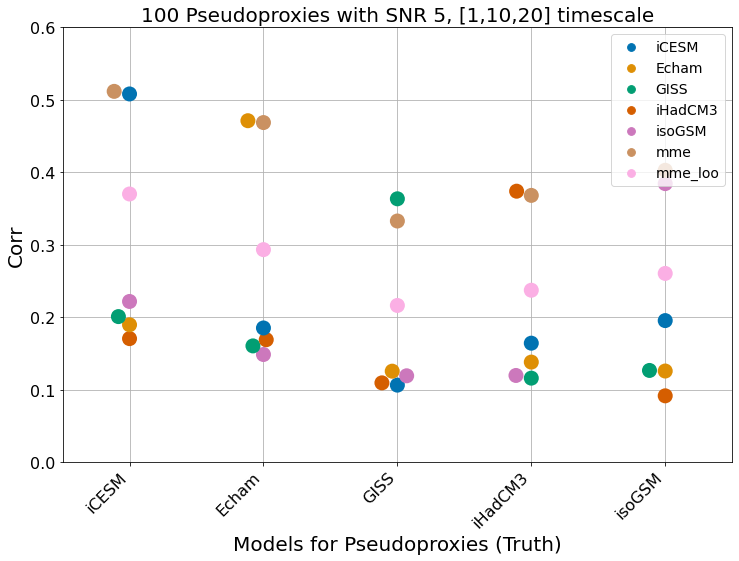

"\nmet='CE'\ndf=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR5_mts/',metric=('tsurf_'+met))\nswarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)\nplt.show()\n"

In [20]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_foreign_model_debiased_SNR5_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 5, [1,10,20] timescale')
plt.show()

"""
met='CE'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR5_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()
"""

In [121]:
cfg_2=copy.deepcopy(cfg)
cfg_2['ppe']['multi_timescale']=[[1,10,20],[1,10,20]]
cfg_2 ['output_folder']='PPE_altphys_debiased_SNR1_mts'
cfg_2['ppe']['SNR']=[[1],[1]]
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  


100%|██████████| 1/1 [00:21<00:00, 21.86s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc



100%|██████████| 1/1 [00:21<00:00, 21.67s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850


100%|██████████| 1/1 [00:21<00:00, 21.26s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:21<00:00, 21.36s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [02:34<00:00, 154.78s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:49<00:00, 109.05s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [12:58<51:52, 778.05s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly


100%|██████████| 1/1 [00:21<00:00, 21.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc


100%|██████████| 1/1 [00:21<00:00, 21.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_85


100%|██████████| 1/1 [00:21<00:00, 21.45s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN P


100%|██████████| 1/1 [00:21<00:00, 21.23s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:21<00:00, 21.18s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [02:39<00:00, 159.13s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:52<00:00, 112.82s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [26:09<39:17, 785.78s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing y


100%|██████████| 1/1 [00:22<00:00, 22.10s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.n


100%|██████████| 1/1 [00:21<00:00, 21.78s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_8


100%|██████████| 1/1 [00:21<00:00, 21.42s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:21<00:00, 21.29s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:21<00:00, 21.28s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [02:39<00:00, 159.09s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /ho


100%|██████████| 1/1 [01:48<00:00, 108.76s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [39:14<26:10, 785.44s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly


100%|██████████| 1/1 [00:21<00:00, 21.81s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
c


100%|██████████| 1/1 [00:21<00:00, 21.53s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_


100%|██████████| 1/1 [00:21<00:00, 21.26s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRI


100%|██████████| 1/1 [00:21<00:00, 21.27s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:21<00:00, 21.25s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  


100%|██████████| 1/1 [02:32<00:00, 152.25s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /hom


100%|██████████| 1/1 [01:52<00:00, 112.03s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [52:17<13:04, 784.60s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 


100%|██████████| 1/1 [00:21<00:00, 21.84s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_195


100%|██████████| 1/1 [00:21<00:00, 21.61s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18


100%|██████████| 1/1 [00:21<00:00, 21.55s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN 


100%|██████████| 1/1 [00:21<00:00, 21.28s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:21<00:00, 21.27s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  fro


100%|██████████| 1/1 [02:32<00:00, 152.31s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /


100%|██████████| 1/1 [01:50<00:00, 110.58s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [1:05:35<00:00, 787.11s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


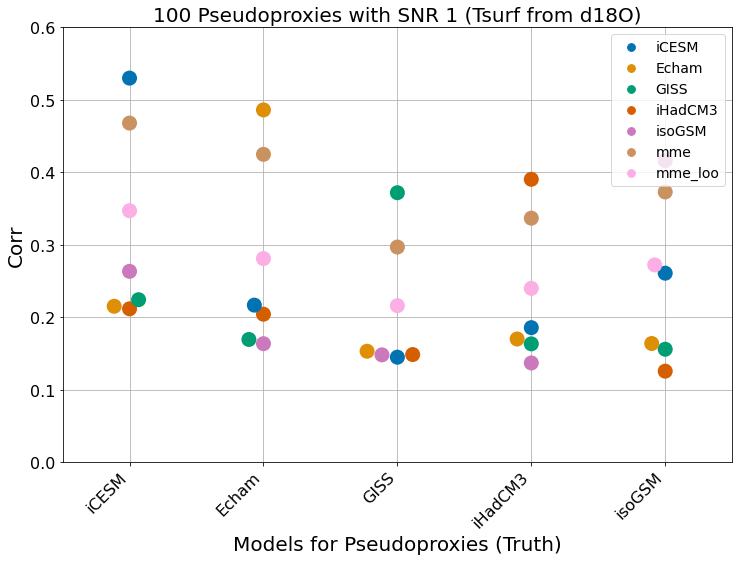

"\nmet='CE'\ndf=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1_mts/',metric=('tsurf_'+met))\nswarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)\nplt.show()\n"

In [31]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 1 (Tsurf from d18O)')
plt.show()

"""
met='CE'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR1_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()
"""

In [122]:
#lower SNR experiment (realistic values)

cfg_2=copy.deepcopy(cfg)
cfg_2['ppe']['multi_timescale']=[[1,10,20],[1,10,20]]
cfg_2 ['output_folder']='PPE_altphys_debiased_SNR0.5_mts'
cfg_2['ppe']['SNR']=[[0.5],[0.5]]
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  


100%|██████████| 1/1 [00:22<00:00, 22.12s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc



100%|██████████| 1/1 [00:21<00:00, 21.91s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850


100%|██████████| 1/1 [00:21<00:00, 21.49s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:21<00:00, 21.37s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:21<00:00, 21.44s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [02:35<00:00, 155.30s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [01:49<00:00, 109.68s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [13:06<52:24, 786.14s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly


100%|██████████| 1/1 [00:22<00:00, 22.14s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc


100%|██████████| 1/1 [00:21<00:00, 21.85s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_85


100%|██████████| 1/1 [00:21<00:00, 21.59s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN P


100%|██████████| 1/1 [00:21<00:00, 21.46s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:21<00:00, 21.39s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [02:30<00:00, 150.15s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from


100%|██████████| 1/1 [01:49<00:00, 109.57s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [26:05<39:05, 781.94s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing y


100%|██████████| 1/1 [00:22<00:00, 22.06s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.n


100%|██████████| 1/1 [00:21<00:00, 21.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_8


100%|██████████| 1/1 [00:21<00:00, 21.55s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PR


100%|██████████| 1/1 [00:21<00:00, 21.39s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:21<00:00, 21.35s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from 


100%|██████████| 1/1 [02:28<00:00, 148.68s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /ho


100%|██████████| 1/1 [01:49<00:00, 109.29s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [38:53<25:51, 775.78s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly


100%|██████████| 1/1 [00:22<00:00, 22.01s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
c


100%|██████████| 1/1 [00:21<00:00, 21.62s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_


100%|██████████| 1/1 [00:21<00:00, 21.42s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRI


100%|██████████| 1/1 [00:21<00:00, 21.33s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:21<00:00, 21.37s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  


100%|██████████| 1/1 [02:36<00:00, 156.12s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /hom


100%|██████████| 1/1 [01:54<00:00, 114.01s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [52:02<13:01, 781.10s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 


100%|██████████| 1/1 [00:21<00:00, 21.36s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_195


100%|██████████| 1/1 [00:21<00:00, 21.29s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18


100%|██████████| 1/1 [00:21<00:00, 21.22s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
COMPUTE ANOMALIES IN MODE: BG+HX
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN 


100%|██████████| 1/1 [00:21<00:00, 21.18s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:21<00:00, 21.13s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  fro


100%|██████████| 1/1 [02:36<00:00, 156.76s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
COMPUTE ANOMALIES IN MODE: BG+HX
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /


100%|██████████| 1/1 [01:51<00:00, 111.80s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [1:05:25<00:00, 785.13s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


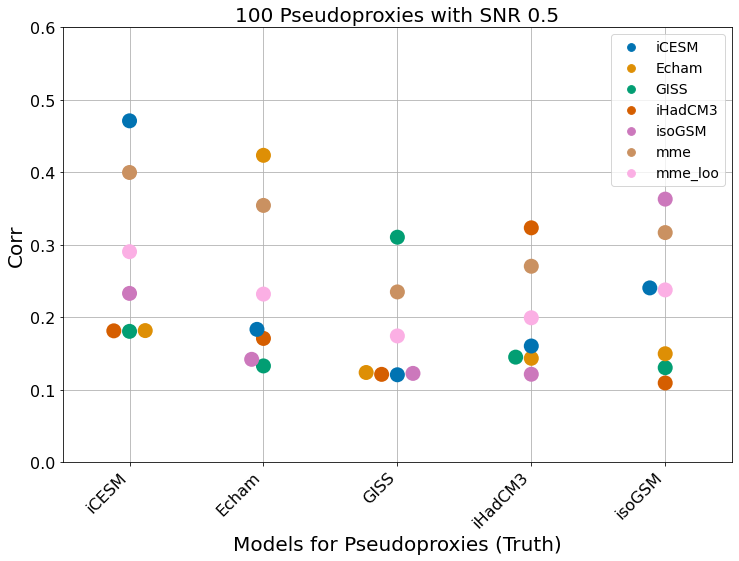

"\nmet='CE'\ndf=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR05_mts/',metric=('tsurf_'+met))\nswarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)\nplt.show()\n"

In [23]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR0.5_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 0.5')
plt.show()

"""
met='CE'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_debiased_SNR05_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()
"""

### All the Previous things without debiasing

-> Do not plot CE, it will be really negative anyway.

In [123]:
cfg_2=copy.deepcopy(cfg)
cfg_2 ['output_folder']='PPE_altphys_SNR5'
cfg_2['ppe']['SNR']=[[5],[5]]
cfg_2['anomaly']=None
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking


100%|██████████| 1/1 [00:12<00:00, 12.82s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average


100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:12<00:00, 12.81s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.81s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:58<00:00, 118.77s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:26<00:00, 86.56s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [11:17<45:10, 677.64s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:12<00:00, 12.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checkin


100%|██████████| 1/1 [00:12<00:00, 12.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly averag


100%|██████████| 1/1 [00:12<00:00, 12.63s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Conf


100%|██████████| 1/1 [00:12<00:00, 12.64s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:12<00:00, 12.74s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [01:53<00:00, 113.83s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [01:26<00:00, 86.30s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [22:27<33:38, 672.99s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for 


100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checki


100%|██████████| 1/1 [00:12<00:00, 12.85s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly avera


100%|██████████| 1/1 [00:12<00:00, 12.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:12<00:00, 12.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.81s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:56<00:00, 116.48s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_da


100%|██████████| 1/1 [01:25<00:00, 85.54s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [33:39<22:25, 672.73s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking 


100%|██████████| 1/1 [00:12<00:00, 12.76s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average



100%|██████████| 1/1 [00:12<00:00, 12.63s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config


100%|██████████| 1/1 [00:12<00:00, 12.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model


100%|██████████| 1/1 [01:54<00:00, 114.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_dat


100%|██████████| 1/1 [01:26<00:00, 86.30s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [45:01<11:16, 676.15s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with p


100%|██████████| 1/1 [00:12<00:00, 12.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Che


100%|██████████| 1/1 [00:12<00:00, 12.59s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly av


100%|██████████| 1/1 [00:12<00:00, 12.68s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Con


100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:12<00:00, 12.78s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mo


100%|██████████| 1/1 [01:52<00:00, 112.28s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_


100%|██████████| 1/1 [01:22<00:00, 82.52s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [56:23<00:00, 676.78s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


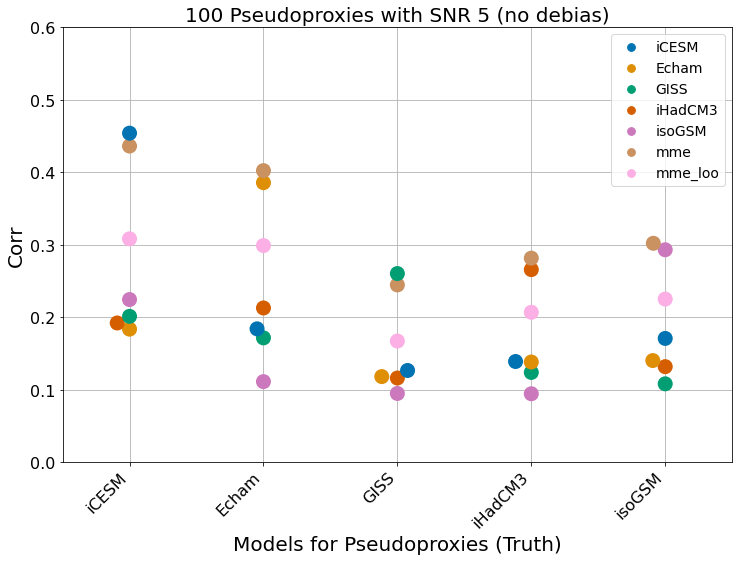

In [25]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_SNR5/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None,title='100 Pseudoproxies with SNR 5 (no debias)')
plt.show()

In [124]:
cfg_2=copy.deepcopy(cfg)
cfg_2 ['output_folder']='PPE_altphys_SNR1'
cfg_2['ppe']['SNR']=[[1],[1]]
cfg_2['anomaly']=None
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking


100%|██████████| 1/1 [00:12<00:00, 12.76s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average


100%|██████████| 1/1 [00:12<00:00, 12.80s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:12<00:00, 12.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [02:01<00:00, 121.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:24<00:00, 84.67s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [11:17<45:10, 677.74s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checkin


100%|██████████| 1/1 [00:12<00:00, 12.87s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly averag


100%|██████████| 1/1 [00:12<00:00, 12.78s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Conf


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:12<00:00, 12.93s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [01:55<00:00, 115.26s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [01:24<00:00, 84.01s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [22:29<33:42, 674.22s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for 


100%|██████████| 1/1 [00:12<00:00, 12.92s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checki


100%|██████████| 1/1 [00:12<00:00, 12.96s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly avera


100%|██████████| 1/1 [00:13<00:00, 13.02s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:12<00:00, 12.98s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.96s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:53<00:00, 113.64s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_da


100%|██████████| 1/1 [01:25<00:00, 85.43s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [33:41<22:26, 673.16s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:12<00:00, 12.93s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking 


100%|██████████| 1/1 [00:12<00:00, 12.96s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average



100%|██████████| 1/1 [00:12<00:00, 12.90s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config


100%|██████████| 1/1 [00:12<00:00, 12.98s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:12<00:00, 12.92s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model


100%|██████████| 1/1 [01:53<00:00, 113.03s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_dat


100%|██████████| 1/1 [01:25<00:00, 85.47s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [44:55<11:13, 673.71s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with p


100%|██████████| 1/1 [00:12<00:00, 12.76s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Che


100%|██████████| 1/1 [00:12<00:00, 12.85s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly av


100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Con


100%|██████████| 1/1 [00:12<00:00, 12.77s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:12<00:00, 12.80s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mo


100%|██████████| 1/1 [01:53<00:00, 113.45s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_


100%|██████████| 1/1 [01:24<00:00, 84.26s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [56:14<00:00, 674.88s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


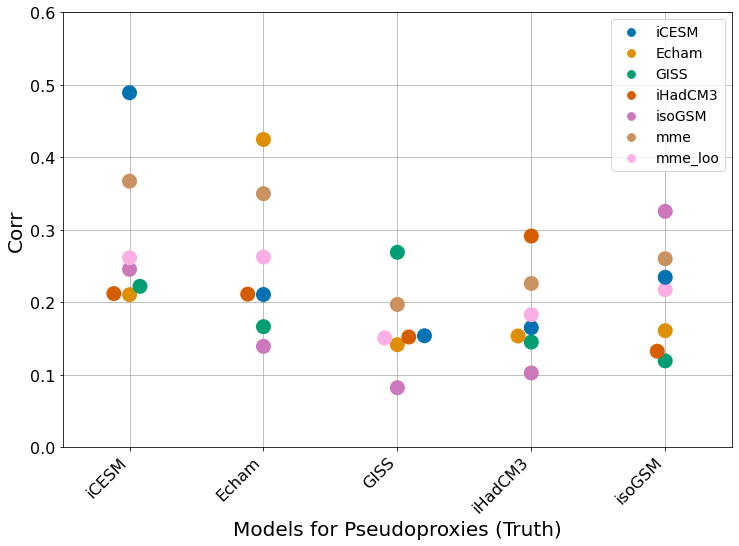

In [26]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_SNR1/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()

In [125]:
#lower SNR experiment (realistic values)
cfg_2=copy.deepcopy(cfg)
cfg_2 ['output_folder']='PPE_altphys_SNR05'
cfg_2['ppe']['SNR']=[[0.5],[0.5]]
cfg_2['anomaly']=None
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking


100%|██████████| 1/1 [00:12<00:00, 12.88s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average


100%|██████████| 1/1 [00:12<00:00, 12.78s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:12<00:00, 12.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.97s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [02:02<00:00, 122.13s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:29<00:00, 89.45s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [11:19<45:19, 679.81s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:12<00:00, 12.85s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checkin


100%|██████████| 1/1 [00:12<00:00, 12.90s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly averag


100%|██████████| 1/1 [00:12<00:00, 12.94s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Conf


100%|██████████| 1/1 [00:12<00:00, 12.94s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:12<00:00, 12.97s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [02:00<00:00, 120.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [01:25<00:00, 85.34s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [22:36<33:54, 678.23s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for 


100%|██████████| 1/1 [00:12<00:00, 12.82s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checki


100%|██████████| 1/1 [00:12<00:00, 12.84s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly avera


100%|██████████| 1/1 [00:13<00:00, 13.17s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:12<00:00, 12.89s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:12<00:00, 12.88s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:57<00:00, 117.36s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_da


100%|██████████| 1/1 [01:25<00:00, 85.80s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [33:47<22:29, 674.74s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:12<00:00, 12.70s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking 


100%|██████████| 1/1 [00:12<00:00, 12.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average



100%|██████████| 1/1 [00:12<00:00, 12.77s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config


100%|██████████| 1/1 [00:12<00:00, 12.97s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:12<00:00, 12.89s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model


100%|██████████| 1/1 [01:55<00:00, 115.63s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_dat


100%|██████████| 1/1 [01:27<00:00, 87.94s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [45:05<11:15, 675.97s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with p


100%|██████████| 1/1 [00:12<00:00, 12.73s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Che


100%|██████████| 1/1 [00:12<00:00, 12.90s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly av


100%|██████████| 1/1 [00:12<00:00, 12.88s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Con


100%|██████████| 1/1 [00:12<00:00, 12.95s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:12<00:00, 12.95s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mo


100%|██████████| 1/1 [01:53<00:00, 113.67s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_


100%|██████████| 1/1 [01:22<00:00, 82.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [56:15<00:00, 675.07s/it]

Output written to iHadCM3_PP_mme_loo_prior.nc


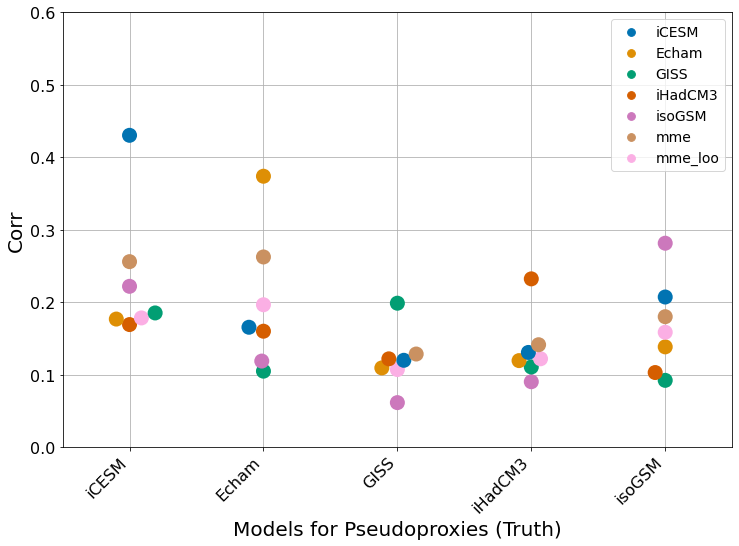

In [27]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_SNR05/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()

In [8]:
#multi-timescale runs
cfg_2=copy.deepcopy(cfg)
cfg_2['ppe']['multi_timescale']=[[1,10,20],[1,10,20]]
cfg_2 ['output_folder']='PPE_altphys_SNR5_mts'
cfg_2['ppe']['SNR']=[[5],[5]]
cfg_2['anomaly']=None
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data


  0%|          | 0/1 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

100%|██████████| 1/1 [00:23<00:00, 23.54s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mch

  0%|          | 0/5 [01:26<?, ?it/s]


KeyboardInterrupt: 

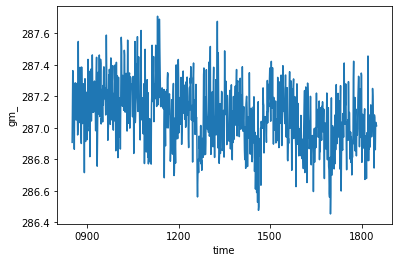

In [9]:
utils.globalmean(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/PPE_altphys_SNR5_mts/iCESM_PP_iCESM_prior_6.nc')['tsurf_mean']).plot()

In [19]:
a=np.array([1,2,3,4,0,4])

In [22]:
not np.any(a==0)

False

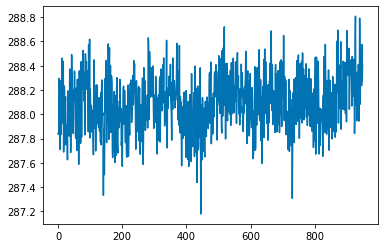

In [48]:
plt.plot(utils.globalmean(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/PPE_altphys_SNR5_mts/Echam_PP_Echam_prior.nc')['tsurf_mean'])[:950])

In [72]:
xr.open_dataset('/home/mchoblet/paleoda/results/experiments/PPE_foreign_model_debiased_SNR5_mts/Echam_PP_Echam_prior.nc')['HXf_m'][980]#['tsurf_mean'][980]

<xarray.DataArray 'HXf_m' (site: 227)>
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
    time     object 1831-01-01 00:00:00
  * site     (site) object '0.2' '0.3' '0.4' '0.7' ... '1.128' '1.107' '1.111'

In [83]:
xr.open_dataset('/home/mchoblet/paleoda/results/experiments/PPE_foreign_model_debiased_SNR5_mts/Echam_PP_Echam_prior.nc')['proxies_res_1'][998:]#['HXf_m'][980]

<xarray.DataArray 'proxies_res_1' (time_res_1: 1, site_1: 227)>
array([[ 0.92268 , -0.593445,  0.351613, ..., -0.136862,  0.212045,  0.013904]])
Coordinates:
  * time_res_1  (time_res_1) object 1849-01-01 00:00:00
  * site_1      (site_1) object '0.2' '0.3' '0.4' ... '1.128' '1.107' '1.111'

In [84]:
xr.open_dataset('/home/mchoblet/paleoda/results/experiments/PPE_foreign_model_debiased_SNR5_mts/Echam_PP_Echam_prior.nc')['proxies_res_1']

<xarray.DataArray 'proxies_res_1' (time_res_1: 999, site_1: 227)>
[226773 values with dtype=float64]
Coordinates:
  * time_res_1  (time_res_1) object 0851-01-01 00:00:00 ... 1849-01-01 00:00:00
  * site_1      (site_1) object '0.2' '0.3' '0.4' ... '1.128' '1.107' '1.111'

In [76]:
xr.open_dataset('/home/mchoblet/paleoda/results/experiments/PPE_foreign_model_debiased_SNR5_mts/Echam_PP_Echam_prior.nc')['tsurf_mean'][980].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

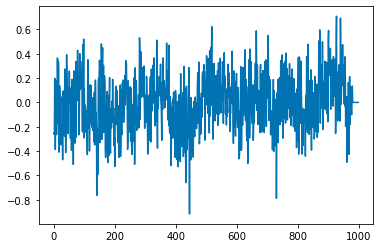

In [50]:
plt.plot(utils.globalmean(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/PPE_foreign_model_debiased_SNR5_mts/Echam_PP_Echam_prior.nc')['tsurf_mean']))

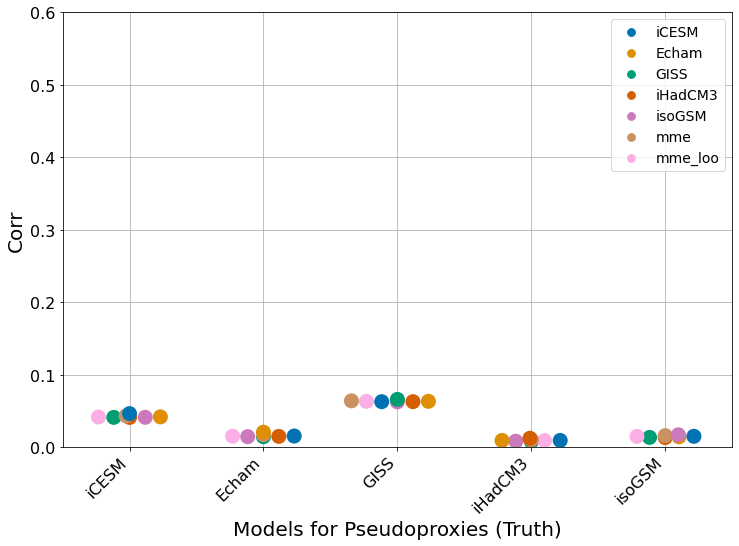

In [28]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_SNR5_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()

In [127]:
cfg_2=copy.deepcopy(cfg)
cfg_2['ppe']['multi_timescale']=[[1,10,20],[1,10,20]]
cfg_2 ['output_folder']='PPE_altphys_SNR1_mts'
cfg_2['ppe']['SNR']=[[1],[1]]
cfg_2['anomaly']=None
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:21<00:00, 21.55s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking


100%|██████████| 1/1 [00:21<00:00, 21.43s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average


100%|██████████| 1/1 [00:21<00:00, 21.34s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:21<00:00, 21.39s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:21<00:00, 21.34s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [02:37<00:00, 157.42s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:53<00:00, 113.69s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [13:03<52:14, 783.71s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:22<00:00, 22.27s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checkin


100%|██████████| 1/1 [00:22<00:00, 22.14s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly averag


100%|██████████| 1/1 [00:21<00:00, 21.79s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Conf


100%|██████████| 1/1 [00:21<00:00, 21.61s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:21<00:00, 21.51s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [02:36<00:00, 156.44s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [01:53<00:00, 113.10s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [26:09<39:15, 785.07s/it]

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for 


100%|██████████| 1/1 [00:22<00:00, 22.27s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checki


100%|██████████| 1/1 [00:21<00:00, 21.92s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly avera


100%|██████████| 1/1 [00:21<00:00, 21.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:21<00:00, 21.47s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:21<00:00, 21.52s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [02:32<00:00, 152.26s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_da


100%|██████████| 1/1 [01:54<00:00, 114.03s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [39:09<26:05, 782.52s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:22<00:00, 22.20s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking 


100%|██████████| 1/1 [00:21<00:00, 21.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average



100%|██████████| 1/1 [00:21<00:00, 21.42s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config


100%|██████████| 1/1 [00:21<00:00, 21.35s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:21<00:00, 21.32s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model


100%|██████████| 1/1 [02:34<00:00, 154.82s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_dat


100%|██████████| 1/1 [01:50<00:00, 110.68s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [52:12<13:02, 782.67s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with p


100%|██████████| 1/1 [00:21<00:00, 21.81s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Che


100%|██████████| 1/1 [00:21<00:00, 21.96s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly av


100%|██████████| 1/1 [00:21<00:00, 21.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Con


100%|██████████| 1/1 [00:50<00:00, 50.15s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:54<00:00, 54.46s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mo


100%|██████████| 1/1 [03:44<00:00, 224.07s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_


100%|██████████| 1/1 [03:44<00:00, 224.65s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_mme_loo_prior.nc


100%|██████████| 5/5 [1:11:00<00:00, 852.17s/it]


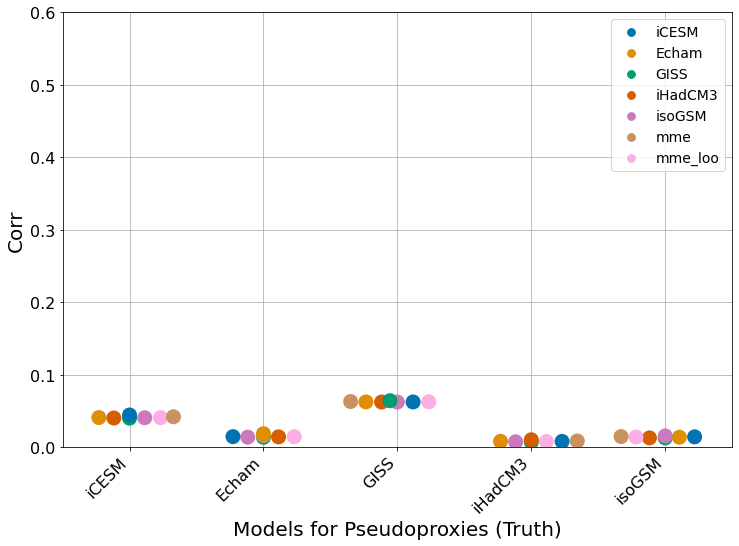

In [29]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_SNR1_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()

In [12]:
cfg_2=copy.deepcopy(cfg)
cfg_2['ppe']['multi_timescale']=[[1,10,20],[1,10,20]]
cfg_2 ['output_folder']='PPE_altphys_SNR05_mts'
cfg_2['ppe']['SNR']=[[0.5],[0.5]]
cfg_2['anomaly']=None
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Load d18O  from  /


  0%|          | 0/1 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

100%|██████████| 1/1 [06:23<00:00, 383.52s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


100%|██████████| 5/5 [07:58<00:00, 95.69s/it]


In [ ]:
cfg_2=copy.deepcopy(cfg)
cfg_2['ppe']['multi_timescale']=[[1,10,20],[1,10,20]]
cfg_2 ['output_folder']='PPE_altphys_SNR05_mts'
cfg_2['ppe']['SNR']=[[0.5],[0.5]]
cfg_2['anomaly']=None
foreign_model_exp(multi_prior_ds,cfg_2)

  0%|          | 0/5 [00:00<?, ?it/s]

>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:26<00:00, 26.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking


100%|██████████| 1/1 [00:53<00:00, 53.69s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average


100%|██████████| 1/1 [00:51<00:00, 51.88s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:26<00:00, 26.16s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:26<00:00, 26.13s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [02:29<00:00, 149.42s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iCESM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [01:50<00:00, 110.62s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 20%|██        | 1/5 [15:08<1:00:33, 908.28s/it]

Output written to iCESM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:22<00:00, 22.24s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checkin


100%|██████████| 1/1 [00:22<00:00, 22.10s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly averag


100%|██████████| 1/1 [00:21<00:00, 21.72s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Conf


100%|██████████| 1/1 [00:21<00:00, 21.48s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/dat


100%|██████████| 1/1 [00:21<00:00, 21.35s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [02:31<00:00, 151.96s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to isoGSM_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mod


100%|██████████| 1/1 [01:50<00:00, 110.85s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 40%|████      | 2/5 [28:08<41:39, 833.19s/it]  

Output written to isoGSM_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for 


100%|██████████| 1/1 [00:22<00:00, 22.00s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checki


100%|██████████| 1/1 [00:21<00:00, 21.78s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly avera


100%|██████████| 1/1 [00:21<00:00, 21.51s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Confi


100%|██████████| 1/1 [00:21<00:00, 21.53s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data


100%|██████████| 1/1 [00:20<00:00, 20.77s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mode


100%|██████████| 1/1 [02:31<00:00, 151.71s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to Echam_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_da


100%|██████████| 1/1 [01:53<00:00, 113.16s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 60%|██████    | 3/5 [41:09<26:57, 808.99s/it]

Output written to Echam_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans



100%|██████████| 1/1 [00:21<00:00, 21.86s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking 


100%|██████████| 1/1 [00:21<00:00, 21.75s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average



100%|██████████| 1/1 [00:21<00:00, 21.58s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config


100%|██████████| 1/1 [00:21<00:00, 21.37s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/data/


100%|██████████| 1/1 [00:20<00:00, 20.81s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model


100%|██████████| 1/1 [02:28<00:00, 148.31s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to GISS_PP_mme_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_dat


100%|██████████| 1/1 [01:49<00:00, 109.01s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


 80%|████████  | 4/5 [54:09<13:17, 797.64s/it]

Output written to GISS_PP_mme_loo_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with p


100%|██████████| 1/1 [00:21<00:00, 21.66s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iCESM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Che


100%|██████████| 1/1 [00:21<00:00, 21.36s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_isoGSM_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Config for  speleo
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly av


100%|██████████| 1/1 [00:21<00:00, 21.24s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_Echam_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc
computing yearly average
Checking prior for nans
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc
computing yearly average
Checking prior for nans
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc
computing yearly average
Checking prior for nans
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc
computing yearly average
Checking prior for nans
Load slp  from  /home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc
computing yearly average
Checking prior for nans
GENERATING PSEUDOPROXIES FROM MODEL OTHER THAN PRIOR
Changed Pseudoproxy-PSM-Con


100%|██████████| 1/1 [00:21<00:00, 21.23s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_GISS_prior.nc
>>>>>LOADING PROXY DATA
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc
computing yearly average
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
Load prec  from  /home/mchoblet/paleoda/da


100%|██████████| 1/1 [00:20<00:00, 20.51s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec
Output written to iHadCM3_PP_iHadCM3_prior.nc
>>>>>LOADING PROXY DATA
Will compute a multi-model-prior!
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc
computing yearly average
Load d18O  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/mo


100%|██████████| 1/1 [02:38<00:00, 158.63s/it]


Finished multitimescale DA
Save variables
Compute pseudoproxy metrics for  tsurf
Compute pseudoproxy metrics for  d18O
Compute pseudoproxy metrics for  prec


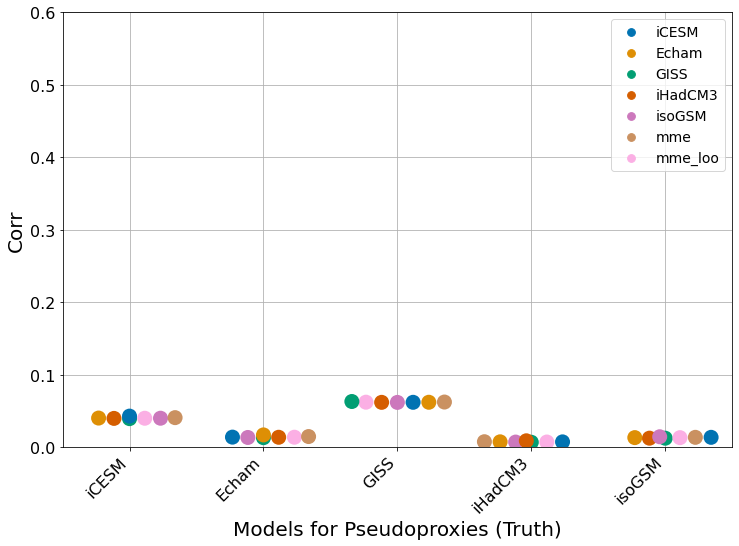

In [30]:
met='Corr'
df=multi_model_dataframe(basepath='/home/mchoblet/paleoda/results/experiments/PPE_altphys_SNR05_mts/',metric=('tsurf_'+met))
swarm_plot(df, name=met,models=['iCESM','Echam','GISS','iHadCM3','isoGSM'], priors=['iCESM','Echam','GISS','iHadCM3','isoGSM','mme','mme_loo'],savename=None)
plt.show()